In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pyspark.sql import SparkSession
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [17]:
# Khởi tạo Spark Session
spark = SparkSession.builder.appName("StockForecasting").getOrCreate()

# Load dữ liệu bằng Spark
file_path = "E:\Folder tai lieu\Lectures\scalable\Stock-Price-Forecasting-System-Using-Apache-Spark-main\data\processed\data.csv"
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Chuyển Spark DataFrame sang Pandas để xử lý
df = df_spark.toPandas()

# Xác định cột target (Close) và các feature khác
features = ['Open', 'High', 'Low', 'Volume', 'Price_Range', 'Daily_Change', 'MA_10', 'MA_50', 'RSI', 'Upper_BB', 'Lower_BB', 'Stoch_Osc']
target = 'Close'

# Chuẩn hóa dữ liệu toàn bộ
df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[features + [target]] = scaler.fit_transform(df[features + [target]])


In [18]:
# ARIMA Model
arima_model = ARIMA(df_scaled[target], order=(5,1,0))
arima_model_fit = arima_model.fit()
y_pred_arima = arima_model_fit.forecast(steps=len(df_scaled))

# Linear Regression Model
X_train = df_scaled[features]
y_train = df_scaled[target]
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_lr = linear_model.predict(X_train)

# LSTM Model
X_train_lstm = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=0)
y_pred_lstm = lstm_model.predict(X_train_lstm).flatten()

# Giả sử chúng ta đã có giá trị thực tế
y_actual = df_scaled[target].values


c:\Users\Phu Bui\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
# Hybrid Model
def hybrid_prediction(y_pred_arima, y_pred_lr, y_pred_lstm, weights=[0.2, 0.3, 0.5]):
    """Kết hợp ba mô hình theo trọng số đã điều chỉnh."""
    return weights[0] * y_pred_arima + weights[1] * y_pred_lr + weights[2] * y_pred_lstm

# Dự đoán mô hình 
y_pred_hybrid = hybrid_prediction(y_pred_arima, y_pred_lr, y_pred_lstm)
# Đánh giá mô hình
def evaluate_model(y_actual, y_pred):
    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return mae, rmse

evaluate_model(y_actual, y_pred_hybrid)

MAE: 0.0394, RMSE: 0.0463


(0.03944167408565027, 0.04630333900561801)

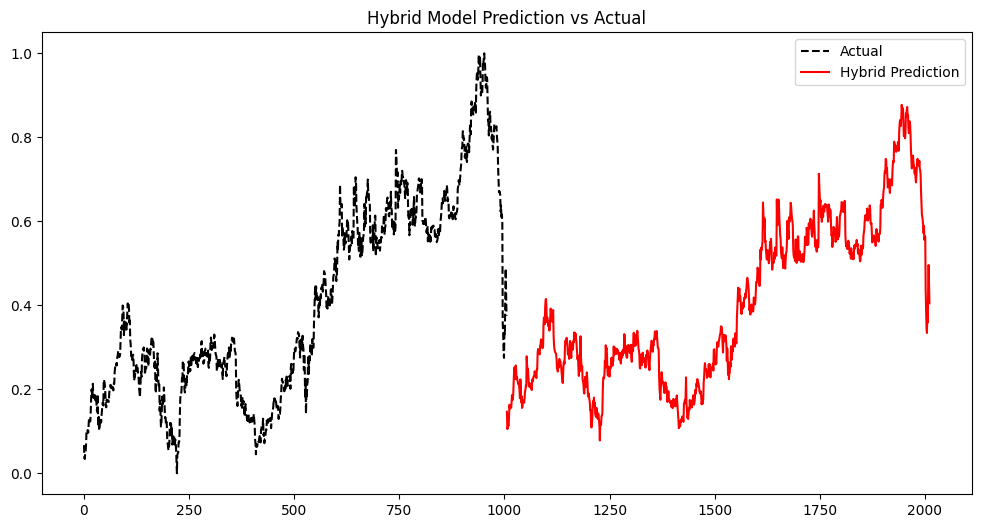

In [20]:
# Trực quan hóa kết quả
plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Actual', color='black', linestyle='dashed')
plt.plot(y_pred_hybrid, label='Hybrid Prediction', color='red')
plt.legend()
plt.title("Hybrid Model Prediction vs Actual")
plt.show()

In [21]:
# Backtesting: Chia tập dữ liệu thành nhiều phần và kiểm tra trên các khoảng thời gian khác nhau
def backtesting(y_actual, y_pred, window=30):
    errors = []
    for i in range(0, len(y_actual) - window, window):
        mae, rmse = evaluate_model(y_actual[i:i+window], y_pred[i:i+window])
        errors.append((mae, rmse))
    return errors

backtesting(y_actual, y_pred_hybrid)

MAE: 0.0534, RMSE: 0.0550
MAE: 0.0420, RMSE: 0.0428
MAE: 0.0288, RMSE: 0.0297
MAE: 0.0146, RMSE: 0.0195
MAE: 0.0232, RMSE: 0.0251
MAE: 0.0222, RMSE: 0.0253
MAE: 0.0574, RMSE: 0.0587
MAE: 0.0576, RMSE: 0.0593
MAE: 0.0180, RMSE: 0.0194
MAE: 0.0128, RMSE: 0.0146
MAE: 0.0097, RMSE: 0.0103
MAE: 0.0146, RMSE: 0.0154
MAE: 0.0276, RMSE: 0.0291
MAE: 0.0456, RMSE: 0.0462
MAE: 0.0530, RMSE: 0.0544
MAE: 0.0350, RMSE: 0.0354
MAE: 0.0212, RMSE: 0.0230
MAE: 0.0253, RMSE: 0.0313
MAE: 0.0119, RMSE: 0.0141
MAE: 0.0147, RMSE: 0.0159
MAE: 0.0344, RMSE: 0.0365
MAE: 0.0344, RMSE: 0.0357
MAE: 0.0406, RMSE: 0.0419
MAE: 0.0344, RMSE: 0.0355
MAE: 0.0485, RMSE: 0.0494
MAE: 0.0560, RMSE: 0.0571
MAE: 0.0493, RMSE: 0.0499
MAE: 0.0434, RMSE: 0.0441
MAE: 0.0446, RMSE: 0.0449
MAE: 0.0530, RMSE: 0.0533
MAE: 0.0804, RMSE: 0.0811
MAE: 0.1115, RMSE: 0.1119
MAE: 0.0796, RMSE: 0.0805


[(0.05342448225206088, 0.054975147542256804),
 (0.04195571879658954, 0.0427575346697894),
 (0.02881246808647762, 0.029661273883538793),
 (0.014617847832296384, 0.019465911135781798),
 (0.023241500065947582, 0.025071231199948946),
 (0.02219776358038014, 0.025250845493396953),
 (0.05744072644061955, 0.058728025885058384),
 (0.05762673096165439, 0.059265206176119765),
 (0.01795808024425695, 0.019440768108887167),
 (0.01281672380822535, 0.014646668583769092),
 (0.009679045606687347, 0.010321765970679084),
 (0.014583486265950846, 0.01539511837144197),
 (0.027591888241510275, 0.029141966007567185),
 (0.04558481905094817, 0.04624954284789976),
 (0.052987023468978336, 0.0543821664620108),
 (0.034977121968520444, 0.035364631108133246),
 (0.021157743288051742, 0.023012410184633326),
 (0.025334405721064372, 0.03126693332164651),
 (0.01188465898703057, 0.014133232912420253),
 (0.014721924199784566, 0.015911211256808448),
 (0.034377038564478976, 0.03651114142620686),
 (0.03435419716181268, 0.035690